In [1]:
import itertools
import warnings
import time
import os
import uuid
import gc
import random as rn

from logging import getLogger, Formatter, StreamHandler, FileHandler, INFO
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from tqdm import tqdm_notebook as tqdm
from contextlib import contextmanager
from joblib import Parallel, delayed
from pathlib import Path

import pywt
import h5py
import vaex
#vaex.multithreading.thread_count_default = 8
import vaex.ml
import dask.dataframe as dd
import dask.array as da
import einops as eo
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import scipy.stats as stats
import cufflinks as cf
import plotly.offline as pyo
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import logging
keras = tf.keras
layers = keras.layers

from IPython.display import display
from dask_ml.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from dask.distributed import Client
from sklearn.pipeline import Pipeline
from sklearn.utils import column_or_1d
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, GroupKFold
from sklearn import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, mean_squared_error
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.utils import get_custom_objects
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.fft import fft, fftfreq, fftshift
from dask.distributed import Client, LocalCluster

from dask_utils import (swapaxes_shuffle, shuffle_blocks_together,
                        stack_interleave_flatten, chunk_generator)

#cluster = LocalCluster(n_workers=1, threads_per_worker=1)
#c = Client(cluster)

# set plotly in notebook mode
init_notebook_mode(connected=True)
# likewise cufflinks for offline use
cf.go_offline()

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
%matplotlib inline

log = logging.getLogger(__name__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load radio signal burst data

This example uses the "DeepSig RADIOML 2018.01A" open dataset provided at:

https://www.deepsig.ai/datasets

The dataset includes both synthetic simulated channel effects and over-the-air recordings of 24 digital and analog modulation types which has been heavily validated.

This dataset was used for [Over-the-air deep learning based radio signal classification](https://arxiv.org/pdf/1712.04578.pdf) published 2017 in IEEE Journal of Selected Topics in Signal Processing, which provides additional details and description of the dataset.

Data are stored in hdf5 format as complex floating point values, with 2 million examples, each 1024 samples long.

These  include  a  number  of  high  ordermodulations (QAM256 and APSK256), which are used in thereal world in very high-SNR low-fading channel environments such as on [impulsive satellite links](https://www.researchgate.net/publication/280972230_Transmission_parameters_optimization_and_receiver_architectures_for_DVB-S2X_systems) (e.g. DVB-S2X).

In [2]:
data_path = '../data/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5'
X_shf_path = '../data/shf.hdf5' # precalculated shuffled sequences

# named types of radio signal for each set of samples in order
classes = [
    '32PSK','16APSK','32QAM','FM','GMSK','32APSK','OQPSK','8ASK',
    'BPSK','8PSK','AM-SSB-SC','4ASK','16PSK','64APSK','128QAM','128APSK',
    'AM-DSB-SC','AM-SSB-WC','64QAM','QPSK','256QAM','AM-DSB-WC','OOK','16QAM'
]
classes = pd.Series(classes).T

Load the arrays for each 1024-sample-long example burst into dask arrays.

- X represents the two-dimensional (I, Q) values for every sample in the burst
- Y represents the one-hot encoded category (corresponding to the signal modulation types above) for each burst
- Z represents the signal-to-noise-ratio (SNR) for each burst

In [3]:
f = h5py.File(data_path, "r")
print("datasets found: ", list(f.keys()))
for k in f.keys():
    print(k, "has shape:", f[k].shape)
# read arrays with Dask
X = da.from_array(f['X'], chunks=('auto', 1024, 2)) # samples * timesteps * features (I, Q)
Y = da.from_array(f['Y'], chunks=(X.chunks[0], -1)) # samples * one-hot-encoded class
Z = da.from_array(f['Z'], chunks=(X.chunks[0], -1)) # samples * SNR

datasets found:  ['X', 'Y', 'Z']
X has shape: (2555904, 1024, 2)
Y has shape: (2555904, 24)
Z has shape: (2555904, 1)


# Exploration

See how the samples are arranged by classification/SNR across the dataset

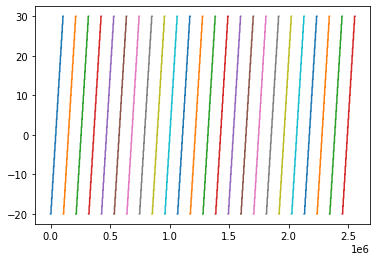

In [4]:
df_clf_snr = pd.DataFrame(
    data=np.vstack(
        [
            da.argmax(Y, axis=1).compute(),
            Z.compute().flatten()
        ]
    ).T,
    columns=['label', 'SNR']
)
# visualise SNR monotonically increasing for each classification across dataset
axs = df_clf_snr.groupby('label')['SNR'].plot()

Cut on SNR > min value (paper reports <10% accuracy for the high negative SNR samples)

In [5]:
min_snr = 8
df_clf_snr_filtered = df_clf_snr.query(f'SNR >= {min_snr}')

In [6]:
# 49152 burst samples per class with SNR > 8
# 4096 samples per SNR per label
print(df_clf_snr_filtered['SNR'].unique().shape[0], "unique SNR values")
df_clf_snr_filtered.reset_index().groupby(['label', 'SNR']).describe()

12 unique SNR values


index                                                           \
            count       mean         std        min         25%        50%   
label SNR                                                                    
0     8    4096.0    59391.5  1182.55768    57344.0    58367.75    59391.5   
      10   4096.0    63487.5  1182.55768    61440.0    62463.75    63487.5   
      12   4096.0    67583.5  1182.55768    65536.0    66559.75    67583.5   
      14   4096.0    71679.5  1182.55768    69632.0    70655.75    71679.5   
      16   4096.0    75775.5  1182.55768    73728.0    74751.75    75775.5   
      18   4096.0    79871.5  1182.55768    77824.0    78847.75    79871.5   
      20   4096.0    83967.5  1182.55768    81920.0    82943.75    83967.5   
      22   4096.0    88063.5  1182.55768    86016.0    87039.75    88063.5   
      24   4096.0    92159.5  1182.55768    90112.0    91135.75    92159.5   
      26   4096.0    96255.5  1182.55768    94208.0    95231.75    96255.5   
      28   4096.0   100351.5  1182.55768    98304.0    99327.75   100351.5   
      30   4096.0   104447.5  1182.55768   102400.0   103423.75   104447.5   
1     8    4096.0   165887.5  1182.55768   163840.0   164863.75   165887.5   
      10   4096.0   169983.5  1182.55768   167936.0   168959.75   169983.5   
      12   4096.0   174079.5  1182.55768   172032.0   173055.75   174079.5   
      14   4096.0   178175.5  1182.55768   176128.0   177151.75   178175.5   
      16   4096.0   182271.5  1182.55768   180224.0   181247.75   182271.5   
      18   4096.0   186367.5  1182.55768   184320.0   185343.75   186367.5   
      20   4096.0   190463.5  1182.55768   188416.0   189439.75   190463.5   
      22   4096.0   194559.5  1182.55768   192512.0   193535.75   194559.5   
      24   4096.0   198655.5  1182.55768   196608.0   197631.75   198655.5   
      26   4096.0   202751.5  1182.55768   200704.0   201727.75   202751.5   
      28   4096.0   206847.5  1182.55768   204800.0   205823.75   206847.5   
      30   4096.0   210943.5  1182.55768   208896.0   209919.75   210943.5   
2     8    4096.0   272383.5  1182.55768   270336.0   271359.75   272383.5   
      10   4096.0   276479.5  1182.55768   274432.0   275455.75   276479.5   
      12   4096.0   280575.5  1182.55768   278528.0   279551.75   280575.5   
      14   4096.0   284671.5  1182.55768   282624.0   283647.75   284671.5   
      16   4096.0   288767.5  1182.55768   286720.0   287743.75   288767.5   
      18   4096.0   292863.5  1182.55768   290816.0   291839.75   292863.5   
      20   4096.0   296959.5  1182.55768   294912.0   295935.75   296959.5   
      22   4096.0   301055.5  1182.55768   299008.0   300031.75   301055.5   
      24   4096.0   305151.5  1182.55768   303104.0   304127.75   305151.5   
      26   4096.0   309247.5  1182.55768   307200.0   308223.75   309247.5   
      28   4096.0   313343.5  1182.55768   311296.0   312319.75   313343.5   
      30   4096.0   317439.5  1182.55768   315392.0   316415.75   317439.5   
3     8    4096.0   378879.5  1182.55768   376832.0   377855.75   378879.5   
      10   4096.0   382975.5  1182.55768   380928.0   381951.75   382975.5   
      12   4096.0   387071.5  1182.55768   385024.0   386047.75   387071.5   
      14   4096.0   391167.5  1182.55768   389120.0   390143.75   391167.5   
      16   4096.0   395263.5  1182.55768   393216.0   394239.75   395263.5   
      18   4096.0   399359.5  1182.55768   397312.0   398335.75   399359.5   
      20   4096.0   403455.5  1182.55768   401408.0   402431.75   403455.5   
      22   4096.0   407551.5  1182.55768   405504.0   406527.75   407551.5   
      24   4096.0   411647.5  1182.55768   409600.0   410623.75   411647.5   
      26   4096.0   415743.5  1182.55768   413696.0   414719.75   415743.5   
      28   4096.0   419839.5  1182.55768   417792.0   418815.75   419839.5   
      30   4096.0   423935.5  1182.55768   421888.0   422911.75   423935.5   
4     8    4096.0   485375.5  1182

Pick out samples with SNR in range

In [7]:
X_filtered = X[df_clf_snr_filtered.index.values]
Y_filtered = Y[df_clf_snr_filtered.index.values]
Z_filtered = Z[df_clf_snr_filtered.index.values]

Grab one signal sample from each class for visualisations

In [8]:
first_samples = (
    df_clf_snr_filtered.reset_index(drop=True).reset_index().groupby(
        ['label']
    ).first()
)
first_sample_indices = first_samples['index'].values

X_samples = X_filtered[first_sample_indices].compute()
Y_samples = Y_filtered[first_sample_indices].compute()
Z_samples = Z_filtered[first_sample_indices].compute()

# 24 samples total of sequences of shape 1024 (samples) * 2 (compoents)
print(X_samples.shape)
print(Y_samples.shape)
print(Z_samples.shape)

(24, 1024, 2)
(24, 24)
(24, 1)


# Visualisation

From the paper: 

"We  use  a second  B210  (with  a  separate  free-running  LO)  to  receive these transmissions in the lab, over a relatively benign indoor wireless channel on the 900MHz ISM band."

I'll assume this means the sampling frequency is 900MHz.

In [9]:
sampling_rate = 9.0e8
N_samples = X_samples.shape[1]
T = 1.0 / sampling_rate
t = np.linspace(0.0, N_samples*T, N_samples)

## 3D time series I/Q components

Visualise I/Q values over time in 3D for each class

In [10]:
# restrict which data to plot (crowded 3D plots are messy)
n_classes_to_visualise = 3
# undersample by a factor of show_nth_sample for clarity
show_nth_sample = 16
# plot and superimpose each example sequence
traces = [
    go.Scatter3d(
        name=classes[first_samples.index][i],
        x=X_samples[i, ::show_nth_sample, 0],
        y=t,
        z=X_samples[i, ::show_nth_sample, 1],
        marker=dict(
            size=4,
            colorscale='Viridis',
        ),
        line=dict(
            width=2
        )
    )
    for i in range(X_samples[:n_classes_to_visualise].shape[0])
]
fig = go.Figure(data=traces)
# set figure layout
fig.update_layout(
    title="I/Q plot over sample sequences of various signal types",
    autosize=False,
    scene=dict(
        xaxis_title='I',
        yaxis_title='time',
        zaxis_title='Q',
        aspectratio = dict( x=1, y=3., z=1 ),
        aspectmode = 'manual'
    ),
)
fig.show()

## In-phase (real) component

In [11]:
show_nth_sample = 1
n_classes_to_visualise = 4

traces = [
    go.Scatter(
        name=classes[first_samples.index][i],
        x=t,
        y=X_samples[i, ::show_nth_sample, 0],
        marker=dict(
            size=4,
            colorscale='Viridis',
        ),
        line=dict(
            width=2
        )
    )
    for i in range(X_samples[:n_classes_to_visualise].shape[0])
]
fig = go.Figure(data=traces)
fig.show()

### Power spectrum

In [38]:
n_classes_to_visualise = 4
show_nth_freq_component = 1
traces = []

# create power spectrum for n samples of different cfns
for ix in range(n_classes_to_visualise):
    # calculate magnitude of fourier components
    yf = fft(X_samples[ix, :, 0] + 1j*X_samples[ix, :, 1])
    yf = 1/N_samples * np.abs(fftshift(yf))
    # set frequency range
    xf = np.linspace(0.0, 1.0/(1.0*T), N_samples)
    xf = fftfreq(N_samples, T)
    xf = fftshift(xf)
    # prepare plot trace
    plot_data = go.Scatter(
        name=classes[first_samples.index][ix],
        x=xf[::show_nth_freq_component],
        y=yf[::show_nth_freq_component],
        marker=dict(
            size=4,
            colorscale='Viridis',
        ),
        line=dict(
            width=2
        )
    )
    traces.append(plot_data)
fig = go.Figure(data=traces)
fig.update_layout(title=f'FFT for samples from first {n_classes_to_visualise} classifications')
fig.show()

# Rearrange data

verify swapaxes shuffle is reordering samples as anticipated, traversing permutations of label/SNR first

In [13]:
pd.DataFrame(
    data=np.vstack(
        [
            da.argmax(swapaxes_shuffle(Y_filtered), axis=1).compute(),
            da.squeeze(swapaxes_shuffle(Z_filtered)).compute()
        ]
    ).T,
    columns=['label', 'SNR']
).head(32)

,label,SNR
0,0,8
1,1,8
2,2,8
3,3,8
4,4,8
5,5,8
6,6,8
7,7,8
8,8,8
9,9,8


perform the swapaxes shuffling on each array to intersperse examples

In [14]:
# for the burst samples themselves, go through an intermediate hdf5 file to avoid dask scheduler
# having a fit and blowing up RAM...
if not Path(X_shf_path).exists():
    swapaxes_shuffle(X_filtered).to_hdf5(X_shf_path, '/X')
f = h5py.File(X_shf_path, "r")
print("datasets found: ", list(f.keys()))
for k in f.keys():
    print(k, "has shape:", f[k].shape)
# read arrays with Dask
X_filtered = da.from_array(f['X'], chunks=('auto', -1, -1)) # samples * timesteps * features (I, Q)

# do classifications and SNRs normally without intermediary file
Y_filtered = swapaxes_shuffle(Y_filtered).rechunk(X_filtered.chunks[0], -1)
Z_filtered = swapaxes_shuffle(Z_filtered).rechunk(X_filtered.chunks[0], -1)

print(X_filtered.numblocks[0], "blocks of size", X_filtered.chunksize[0])
assert X_filtered.numblocks[0] == Y_filtered.numblocks[0]

datasets found:  ['X']
X has shape: (1179648, 1024, 2)
73 blocks of size 16320


In [15]:
X_sum = X_filtered.sum(axis=1).compute()

Split into 53 train / 10 validation / 10 test

In [16]:
X_train, X_val, X_test = X_filtered.blocks[:53], X_filtered.blocks[53:63], X_filtered.blocks[63:]
Y_train, Y_val, Y_test = Y_filtered.blocks[:53], Y_filtered.blocks[53:63], Y_filtered.blocks[63:]
Z_train, Z_val, Z_test = Z_filtered.blocks[:53], Z_filtered.blocks[53:63], Z_filtered.blocks[63:]

# Preprocessing

In [17]:
def make_X_pipeline():
    """
    Input data training pipeline. Simple Z-score rescaling.
    
    Returns
    -------
    :obj:`sklearn.pipeline.Pipeline`
        A pipeline for preprocessing input signal samples. Currently
        just simple scaling.
    """
    steps = [
        ('scaler', StandardScaler()),
    ]
    return Pipeline(steps)

Perform preprocessing

In [18]:
# apply z-score scaling to samples (~2m)
X_pipeline = make_X_pipeline()
X_train = X_pipeline.fit_transform(X_train)
X_val = X_pipeline.transform(X_val)
X_test = X_pipeline.transform(X_test)

Define function to perform batch generation from delayed arrays

In [19]:
def batch_generator(
    X:da.Array,
    Y:da.Array,
    batch_size:int,
    augger=None,
    client=None,
    seed:int=42,
    shuffle_blocks_every_epoch:bool=False,
    shuffle_within_blocks:bool=True,
    float32=True
 ) -> Tuple[np.array, np.array]:
    """
    Generates batches of X/Y pairs from dask arrays.
    
    Proceeds chunk by chunk through the dask array, generating smaller numpy
    arrays of the appropriate `batch_size` from these as it goes along. Optionally
    applies augmentations to each of these.
    
    Parameters
    ----------
    X:  :obj:`dask.array.Array`
        A dask array of training examples with samples distributed along 0
    Y:  :obj:`dask.array.Array`
        A dask array of training ground truth labels with samples along axis 0
    batch_size: int
        The batch size of the yielded arrays
    augger: callable, optional
        A function applying augmentations to batches (X, Y)
    client: :obj:`distributed.Client`, optional
        Dask distributed client for mapping parallel augmentation jobs
    seed: int, optional
        Random seed
    shuffle: bool, optional
        Flags whether to shuffle within the chunks.
    float32: bool, optional
        Flags whether to coerce conversion of arrays to float32 before yielding
        
    Yields
    ------
    tuple of :obj:`numpy.ndarray`:
        (images, masks) with augmentations applied and shape (batch_size, h, w, c)
    """
    # instantiate distributed scheduler if not passed
    if client is None:
        close_client_after = True
        client = Client() 
    # track nsamples
    n_samples = X.shape[0]
    # seed numpy
    if seed:
        np.random.seed(seed)
    # keep yielding
    epochs = 0
    # -- loop over whole dask array
    while True:
        # get chunk generator for larger-than-memory image and mask arrays
        chunk_gen =  chunk_generator([X, Y], shuffle_blocks=shuffle_blocks_every_epoch)
        # for each image/mask chunk in RAM, do a chunk-epoch worth of
        # data-augmented batch generation
        # -- loop over chunks: these are now numpy arrays
        for i, (X_chunk, Y_chunk) in enumerate(chunk_gen):
            log.debug(f"Dask Chunk: {i+1}\n")
            # get indices of chunk
            n_samples_chunk = X_chunk.shape[0]
            n_batches_chunk = int(n_samples_chunk/batch_size)
            index = np.arange(0, n_samples_chunk)
            # optionally shuffle inplace
            if shuffle_within_blocks:
                np.random.shuffle(index)
            start_point, batches = 0, 0 # track processed samples and batches
            # -- loop over batches in chunk
            while True:
                log.debug(f"Batch: {batches}")
                inds = index[start_point:start_point+batch_size]
                Xb, Yb = X_chunk[inds], Y_chunk[inds]
                # optionally augment this batch
                if augger is not None:
                    Xb, Yb = augment_all(Xb, Yb, augger, client)
                if float32:
                    Xb = Xb.astype('float32')
                    Yb = Yb.astype('float32')
                # try to clean up autocreated client if tf stops iteration
                try:
                    yield Xb, Yb
                except StopIteration:
                    if close_client_after:
                        client.close()
                    raise
                start_point += batch_size
                batches += 1
                # stop if we reach the end of the chunk
                if batches >= n_batches_chunk:
                    break
        # -- epoch end
        epochs += 1
        log.debug(f"Finished generating epoch: {epochs}!\n")

# Model definition

## WaveNet classifier

We'll use a WaveNet-like architecture, these are pretty lightweight and very good at capturing signal characteristics at multiple time scales.

These are basically 1D-convolutional networks with multiple dilations along the time dimension conducted and assimialted in each layer. These are sometimes referred to as Temporal Convolutional Networks (TCNs).

Here we also use residual connections in each block.

Some of the performance-optimisation-related modifications here (like Mish and the mixed activation functions) are adapted from Kaggle competition winners such as these ones:

- https://www.kaggle.com/teejmahal20/wavenet-keras-kalman-filter-pre-processing
- https://www.kaggle.com/siavrez/wavenet-keras

In [25]:
class Mish(layers.Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [43]:
def WaveNetResidualConvBlock1D(
    num_filters:int,
    kernel_size:int,
    n_dilations:int
):
    """
    A Residual "WaveNet" Block. 
    
    Essentially a stack of n_dilations 1D convolutional layers, each with num_filters 
    and kernel_size. The first layer's filters resolve successive entries in the input 
    sequence, while subsequent layers resolve every 2nd, 4th, ... 2^(n_dilations-1).
    
    Parameters
    -----------------
    num_filters: int
        The number of filters in each constituent 1D convolutional layer.
    kernel_size: int
        The kernel size for each convolutional layer's filters
    n_dilations: int
        The number of different dilations (ranging from stride length 1 to 2^n_dilations).
        For example n_dilations = 3 implies 3 convolutional layers are assembled with 
        stride lengths 1, 2 and 4.
        
    Returns
    -----------
    function:
        A function that builds and applies the convolutional filters to its input sequence
    """
    def build_residual_block(x):
        resid_input = x
        for dilation_rate in [2**i for i in range(n_dilations)]:
            l_sigmoid_conv1d = layers.Conv1D(
                num_filters, kernel_size, dilation_rate=dilation_rate,
                padding='same', activation='sigmoid'
            )(x)
            l_tanh_conv1d = layers.Conv1D(
                num_filters, kernel_size, dilation_rate=dilation_rate,
                padding='same', activation='Mish'
            )(x)
            x = layers.Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
            x = layers.Conv1D(num_filters, 1, padding='same')(x)
            resid_input = layers.Add()([resid_input ,x])
        return resid_input
    return build_residual_block

In [54]:
def WaveNetClassifier(
    input_shape:Tuple[int],
    n_filters:int=16,
    kernel_size:int=3,
    layer_max_dilation_factors:List[int]=[12,8,4,1],
    n_output_classes:int=24
) -> models.Model:
    """
    Builds a WaveNet-style convolutional signal classifier
    
    Parameters
    -----------------
    input_shape: tuple of int
        The shape of each input sequence. For example, (1024, 2) for 1024 samples of 2 variables.
    n_filters: int, optional
        The base number of convolutional filters (per dilation rate) in a wavenet block. Each layer
        doubles this (this is an empirically effective heuristic).
    kernel_size: int, optional
        The size of the 1D (dilated) convolution kernels. 
    layer_max_dilation_factors: list of int, optional
        The max dilation rates per layer. Specifies the number of layers implicitly. For example, if 
        [12, 8] there will be two layers.  The first will use a stack of 12 1D convolutions ranging from 
        stride lengths of 1 to 2^(12-1) = 2048, each with num_filters kernels. The second will use a 
        stack of 8 1D convolutionsn of stride 1 to 2^(8-1) = 128, each with num_filters*2 kernels.
    n_output_classes: int, optional
        The number of output classifications which will be predicted
    dropout: float, optional
        Dropout fraction to apply to final 
    Returns
    -----------
    tf.keras.Model:
        The (uncompiled) model
    """
    l_input = layers.Input(shape=(input_shape))
    x = l_input
    layer_filters = n_filters
    # stack wavenet blocks
    for df_max_layer in layer_max_dilation_factors:
        x = layers.Conv1D(layer_filters, 1, padding='same')(x)
        x = WaveNetResidualConvBlock1D(layer_filters, kernel_size, df_max_layer)(x)
        layer_filters *= 2
    # collapse sequences to output class vector
    x = layers.Conv1D(n_output_classes, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Softmax()(x)
    return models.Model(inputs=[l_input], outputs=[outputs])

In [56]:
m2= WaveNetClassifier(X_train.shape[1:])

In [57]:
m2.load_weights('weights.hdf5')

In [47]:
X_train.shape[1:]

(1024, 2)

In [27]:
model = WaveNetClassifier(X_train.shape[1:])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 2)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1024, 16)     48          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1024, 16)     784         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1024, 16)     784         conv1d[0][0]                     
______________________________________________________________________________________________

In [28]:
epochs = 10
batch_size = 64
optimiser = 'adam'
lr_init = 1e-4
lr_reduce_factor = 0.5
lr_reduce_patience = 2
lr_min = 1e-6
patience = 3

train_steps = X_train.shape[0]//batch_size
val_steps = X_val.shape[0]//batch_size
batches_per_block = X_train.blocks[0].shape[0] / batch_size
print(train_steps, "train steps")
print(batches_per_block, "batches per block") # don't want to queue up more than one extra block for RAM

13515 train steps
255.0 batches per block


In [29]:
# interpret optimizer
if optimiser == 'sgd':
    opt = tf.keras.optimizers.SGD(
        learning_rate=lr_init, momentum=0.85, nesterov=False
    )
elif optimiser == 'adam':
    opt = tf.keras.optimizers.Adam(
        learning_rate=lr_init, beta_1=0.9, beta_2=0.999, amsgrad=False
    ) # check out RADAM?
else:
    raise ValueError(f"Optimiser {opt} not understood")        
opt = tfa.optimizers.SWA(opt)
    
# specify training directory to save weights and metrics for this loss_fn and data ID
# within models_dir
models_dir = Path('../models')
project_name = Path(f'WaveNetClassifier_{uuid.uuid4()}')
training_dir = Path(models_dir) / project_name
training_dir.mkdir(parents=True, exist_ok=True)

In [30]:
# -- callbacks

# early stopping
monitor = 'val_loss'
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor, patience=patience)
]

In [ ]:
# reduce the learning rate on plateaus
callbacks.append(
    tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor,
                                         factor=lr_reduce_factor,
                                         patience=lr_reduce_patience,
                                         min_lr=lr_min)
)

In [ ]:
# set up tensorboard to record metrics in a subdirectory
tb_pth = training_dir / Path("metrics/")
tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir=str(tb_pth),
    update_freq=50
)
callbacks.append(tb_cb)

In [31]:
# set up checkpoints in the training directory
cp_fmt = 'cp-e{epoch:02d}-l{loss:.5f}-a{accuracy:.4f}'
suffix = '-vl{val_loss:.5f}-va{val_accuracy:.4f}.ckpt'
cp_fmt = cp_fmt + suffix
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(training_dir / Path(cp_fmt)), # saved_model
    monitor=monitor,
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
callbacks.append(cp_callback)

In [32]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

In [33]:
# quickly check
X_train_blk_0 = X_train.blocks[0].compute()
Y_train_blk_0 = Y_train.blocks[0].compute()
Y_train_blk_0_cls = [classes[ix] for ix in np.argmax(Y_train_blk_0, axis=1)]

In [34]:
show_nth_sample = 1
n_classes_to_visualise = 24

traces = [
    go.Scatter(
        name=Y_train_blk_0_cls[i],
        x=t,
        y=X_train_blk_0[i, ::show_nth_sample, 0],
        marker=dict(
            size=4,
            colorscale='Viridis',
        ),
        line=dict(
            width=2
        )
    )
    for i in range(X_train_blk_0[:n_classes_to_visualise].shape[0])
]
fig = go.Figure(data=traces)
fig.show()

In [35]:
model.fit(
    fancy_batch_generator(X_train, Y_train, batch_size=batch_size, shuffle_blocks_every_epoch=False, shuffle_within_blocks=False),
    steps_per_epoch=train_steps, # steps per epoch
    epochs=epochs,
    validation_data=fancy_batch_generator(X_val, Y_val, batch_size=batch_size),
    validation_steps=val_steps,
    max_queue_size=batches_per_block-1,
    callbacks=callbacks
)

Epoch 1/10


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


13515/13515 [==============================] - 2166s 160ms/step - loss: 1.4547 - accuracy: 0.5479 - val_loss: 0.8311 - val_accuracy: 0.6961 - lr: 1.0000e-04
Epoch 2/10
13515/13515 [==============================] - 2153s 159ms/step - loss: 1.0572 - accuracy: 0.6791 - val_loss: 0.6436 - val_accuracy: 0.7757 - lr: 1.0000e-04
Epoch 3/10
13515/13515 [==============================] - 2167s 160ms/step - loss: 0.8903 - accuracy: 0.7415 - val_loss: 0.4074 - val_accuracy: 0.8710 - lr: 1.0000e-04
Epoch 4/10
13515/13515 [==============================] - 2169s 160ms/step - loss: 0.6679 - accuracy: 0.8191 - val_loss: 0.2298 - val_accuracy: 0.9260 - lr: 1.0000e-04
Epoch 5/10
13515/13515 [==============================] - 2162s 160ms/step - loss: 0.5648 - accuracy: 0.8461 - val_loss: 0.1920 - val_accuracy: 0.9470 - lr: 1.0000e-04
Epoch 6/10
13515/13515 [==============================] - 2124s 157ms/step - loss: 0.5256 - accuracy: 0.8550 - val_loss: 0.1784 - val_accuracy: 0.9437 - lr: 1.0000e-04
Epo

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [36]:
model.save_weights('weights.hdf5')

In [ ]:
def make_cm_df(y_pred, y_true, classes):
    """ make the confusion matrix dataframe """
    # check we have a sample of every class in validation dataset
    #assert len(classes) == np.unique(y_true).shape[0], (
    #    f"{len(classes)} classes but only {np.unique(y_true).shape[0]} represented in data!"
    #)
    #print(classes)
    # make cm, swapping pred/true to get our preferred convention (opposite to sklearn)
    cm = confusion_matrix(y_true=y_pred, y_pred=y_true, labels=classes)
    # stick the CM in a dataframe
    col_labs = {i:'true_' + classes[i] for i in range(len(classes))}
    row_labs = {i:'pred_' + classes[i] for i in range(len(classes))}
    df_cm = pd.DataFrame(index=pd.Series(row_labs), columns=pd.Series(col_labs), data=cm)
    #print(col_labs)
    #print(row_labs)
    #print(df_cm)
    # calculate total predicted/true in each class
    df_cm.loc['true_total', :] = df_cm.sum()
    df_cm['predicted_total'] = df_cm.sum(axis=1)
    # calculate recalls and precisions for each class
    for i in range(len(classes)):
        df_cm.loc['recall', df_cm.columns[i]] = np.round(df_cm.iloc[i, i]/df_cm.loc['true_total', df_cm.columns[i]],2)
        df_cm.loc[df_cm.index[i], 'precision'] = np.round(df_cm.iloc[i, i]/df_cm.loc[df_cm.index[i], 'predicted_total'],
    # put pre70 class first in ordering (should be just one var with '1970' in the name!)
    pre70_classes = [c for c in classes if '1970' in c]
    if len(pre70_classes) > 1:
        raise ValueError(
            f"more than one class with '1970' in the name - cant determine column ordering"
            f"INFO: {pre70_classes}"
        )
    try:
        pre70_class = pre70_classes[0]
        p70_row, p70_col = f'pred_{pre70_class}', f'true_{pre70_class}'
        ocols, orows = df_cm.columns.tolist(), df_cm.index.tolist()
        ocols.remove(p70_col), orows.remove(p70_row)
        ocols[:0], orows[:0] = [p70_col], [p70_row]
    except IndexError:
        ocols, orows = df_cm.columns.tolist(), df_cm.index.tolist()
    try:
        df_cm = df_cm[ocols]
        df_cm = df_cm.reindex(orows)
    except Exception as e:
        print("Error reordering rows/columns. Returning Confusion Matrix dataframe as is: ", e)
    finally:
        return df_cm

In [ ]:
def plot_cm(cm_df, title="Confusion Matrix"):
    max_n = np.nanmax(cm_df.values)
    z = cm_df.values.copy()
    x = cm_df.columns.tolist()
    y =  cm_df.index.tolist()

    # change each element of z to type string for annotations
    z_text = [[f"<i><b>{str(y)}</b></i>" for y in x] for x in z]
    # now change the "z" values for prec/rec to be the same colourscale
    z[-1] *= max_n
    z[:, -1] *= max_n
    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text=f'<i><b>{title}</b></i>')

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Real value",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Predicted value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    fig['layout']['yaxis']['autorange'] = "reversed"
    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()
    return fig